In [1]:
# Sbi
import sbi
from sbi import utils as utils
from sbi.inference import SNLE, simulate_for_sbi

# Sbi benchmark
import sbibm
from sbibm.metrics import c2st

# torch and so
import torch
from torch import nn
import torch.distributions as distrib
import numpy as np

# Pyro thinks
import pyro
from pyro.distributions import transforms
from pyro.optim import Adam
from pyro.nn import AutoRegressiveNN, DenseNN

import matplotlib.pyplot as plt

from alternative_divergence import ElboOptimizer, RenjeyDivergenceOptimizer

In [2]:
moons = sbibm.get_task("two_moons") 
moons_prior = moons.prior_dist
moons_simulator = moons.get_simulator()
moons_observation = moons.get_observation(num_observation=1) 

# two moons data
moons_thetas = moons_prior.sample((10000,))
moons_xs = moons_simulator(moons_thetas)

In [3]:
from sbi import inference 
from sbi.inference.posteriors.variational_posterior import build_flow
inf = inference.SNLVI(moons_prior)
density_estimator = inf.append_simulations(moons_thetas, moons_xs).train()

Neural network successfully converged after 169 epochs.


In [4]:
posterior = inf.build_posterior(density_estimator)
posterior.set_default_x(moons_observation)

VariationalPosterior(
               method_family=snle,
               net=<a Flow, see `.net` for details>,
               prior=Independent(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1),
               x_shape=torch.Size([1, 2]))
               

# Variational Inference with Renyi Divergences

The general form of an alpha divergence is given by
$$ D_\alpha(p||q) = \frac{1}{\alpha-1} \log \int p(\theta)^\alpha q(\theta)^{1-\alpha} d\theta$$

Several common divergences are in this family e.g. for $\alpha \rightarrow 1$ we obtian the KL divergence. For $\alpha = 0.5$ the Hellinger distance and for $\alpha=2$ something proportional to the chi square divergence.

We can write the objective as 
$$ \mathcal{L}_\alpha (q) = \frac{1}{1-\alpha} \log \mathbb{E}_q \left[ \left( \frac{p(\theta, x)}{q(\theta)}  \right)^{1-\alpha}\right]$$

Note the log is outside the expectation, hence we have to do it over the ration of densities. Note that this is numerically very unstable. Nontheless we can take stabely estiamte its gradients by
$$ \nabla_\phi \mathcal{L}_\alpha (q_\phi) = \mathbb{E}\left[ w_\alpha \nabla_\phi \log \frac{p(\theta, x)}{q(\theta)} \right]$$ 
with 
$$w_\alpha = \left(\frac{p(\theta, x)}{q(\theta)} \right)^{1-\alpha} / \mathbb{E}\left[\left(\frac{p(\theta, x)}{q(\theta)} \right)^{1-\alpha} \right]$$
Hence it can be interpreted as an importance weighted ELBO particles. We have two cases
* If $\frac{p(\theta, x)}{q(\theta)}$ is large this means that $p(\theta, x) >> q(\theta)$. Hence $q$ does not cover the support of $p$. For $\alpha \rightarrow - \infty$, this elbo particle is weighted very high! Hence induces **support covering** behaviour.
* If $\frac{p(\theta, x)}{q(\theta)}$ is small this means that $p(\theta, x) << q(\theta)$. Hence $q$ does not cover a mode of $p$. For $\alpha \rightarrow  \infty$, this elbo particle is weighted very high! Hence induces **mode seeking** behaviour.

In [18]:
posterior.q = build_flow(posterior._prior, permute=True, type="spline_autoregressive", num_flows=5)
opt = ElboOptimizer(posterior, elbo_particles=512, optimizer=torch.optim.Adam)

In [19]:
for i in range(1000):
    loss = opt.step(moons_observation)
    print(loss)

tensor(143.8974)
tensor(134.5787)
tensor(134.3266)
tensor(124.1007)
tensor(125.4896)
tensor(128.4555)
tensor(121.3751)
tensor(116.6106)
tensor(109.1613)
tensor(108.7501)
tensor(109.2940)
tensor(101.6211)
tensor(100.9128)
tensor(95.8545)
tensor(97.1755)
tensor(89.1047)
tensor(95.6490)
tensor(88.3373)
tensor(80.3524)
tensor(78.8227)
tensor(80.2398)
tensor(75.3018)
tensor(76.8607)
tensor(72.3842)
tensor(69.3104)
tensor(71.5768)
tensor(68.6866)
tensor(62.7565)
tensor(66.3615)
tensor(65.9242)
tensor(59.8113)
tensor(60.2984)
tensor(57.5820)
tensor(49.5744)
tensor(52.0477)
tensor(50.3477)
tensor(48.3976)
tensor(48.0462)
tensor(45.7166)
tensor(46.7116)
tensor(43.5765)
tensor(42.4505)
tensor(40.0991)
tensor(37.0472)
tensor(37.4209)
tensor(38.4758)
tensor(37.5896)
tensor(39.1593)
tensor(36.3207)
tensor(32.8199)
tensor(32.2770)
tensor(32.8626)
tensor(31.1667)
tensor(32.8684)
tensor(29.1657)
tensor(28.3414)
tensor(28.7685)
tensor(29.2794)
tensor(27.2118)
tensor(27.6379)
tensor(26.3481)
tensor(27.0

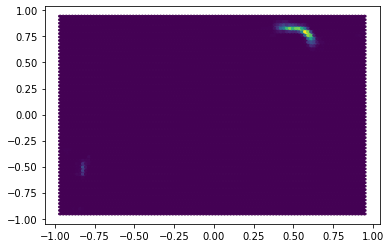

In [20]:
samples = posterior.q.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

In [21]:
posterior.q = build_flow(posterior._prior, permute=True, type="spline_autoregressive", num_flows=5)
opt = RenjeyDivergenceOptimizer(posterior, alpha=0.5, elbo_particles=512, optimizer=torch.optim.Adam)

In [22]:
for i in range(1000):
    loss = opt.step_surrogated(moons_observation)
    print(loss)

tensor(5.1431)
tensor(4.1435)
tensor(4.3715)
tensor(5.2630)
tensor(4.3647)
tensor(4.7002)
tensor(4.9943)
tensor(5.1222)
tensor(5.4999)
tensor(4.7762)
tensor(4.8707)
tensor(4.3020)
tensor(5.6050)
tensor(4.5867)
tensor(4.6394)
tensor(3.9221)
tensor(4.0514)
tensor(3.7370)
tensor(3.4896)
tensor(4.7167)
tensor(4.5987)
tensor(4.1699)
tensor(2.8137)
tensor(2.8778)
tensor(3.3627)
tensor(3.6900)
tensor(3.7109)
tensor(3.2190)
tensor(3.5560)
tensor(3.4620)
tensor(2.7343)
tensor(3.3375)
tensor(3.3279)
tensor(2.9403)
tensor(3.3152)
tensor(3.2765)
tensor(2.8766)
tensor(3.2249)
tensor(3.2368)
tensor(3.0403)
tensor(2.7849)
tensor(2.6021)
tensor(3.4653)
tensor(2.9681)
tensor(3.0959)
tensor(3.0377)
tensor(3.1996)
tensor(3.2589)
tensor(2.9581)
tensor(3.0892)
tensor(3.3683)
tensor(2.8456)
tensor(3.0435)
tensor(2.8663)
tensor(2.5564)
tensor(2.5574)
tensor(2.8485)
tensor(2.5651)
tensor(2.6528)
tensor(2.9826)
tensor(2.8681)
tensor(2.6215)
tensor(2.8250)
tensor(2.5327)
tensor(2.8656)
tensor(3.0238)
tensor(2.5

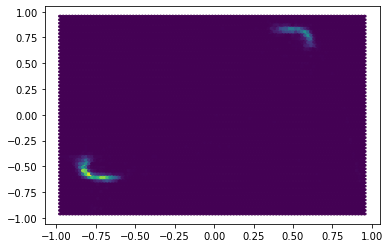

In [23]:
samples = posterior.q.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

In [36]:
posterior.q = build_flow(posterior._prior, permute=True, type="iaf", num_flows=10)
opt = ElboOptimizer(posterior, elbo_particles=512, optimizer=torch.optim.Adam)

In [37]:
for i in range(1000):
    loss = opt.step(moons_observation)
    print(loss)

tensor(53.7655)
tensor(54.1001)
tensor(49.5606)
tensor(50.4188)
tensor(47.5724)
tensor(47.6207)
tensor(44.2214)
tensor(43.9376)
tensor(41.0468)
tensor(40.5631)
tensor(38.2148)
tensor(41.7162)
tensor(39.8225)
tensor(38.5075)
tensor(39.6912)
tensor(36.4571)
tensor(34.2533)
tensor(35.3821)
tensor(31.7484)
tensor(31.5457)
tensor(31.5826)
tensor(29.3240)
tensor(29.3506)
tensor(29.0212)
tensor(28.4439)
tensor(28.3645)
tensor(27.1715)
tensor(26.6819)
tensor(27.1597)
tensor(24.8868)
tensor(26.2245)
tensor(22.2701)
tensor(23.2766)
tensor(23.1724)
tensor(23.0076)
tensor(19.5895)
tensor(22.3112)
tensor(21.1168)
tensor(19.7888)
tensor(20.3367)
tensor(19.5119)
tensor(17.8940)
tensor(18.6674)
tensor(18.2491)
tensor(16.8374)
tensor(15.9762)
tensor(15.7886)
tensor(15.9181)
tensor(14.0295)
tensor(15.5565)
tensor(15.4766)
tensor(14.2465)
tensor(13.3834)
tensor(12.1855)
tensor(12.1334)
tensor(11.4854)
tensor(9.9938)
tensor(11.8932)
tensor(10.4308)
tensor(10.2134)
tensor(10.4091)
tensor(9.4897)
tensor(10.

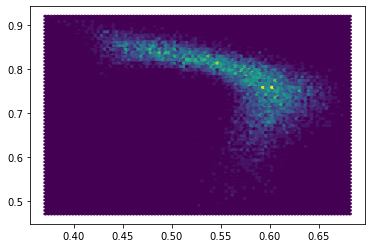

In [38]:
samples = posterior.q.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

In [42]:
posterior.q = build_flow(posterior._prior, permute=True, type="iaf", num_flows=10)
opt = RenjeyDivergenceOptimizer(posterior, alpha=-0.5, elbo_particles=512, optimizer=torch.optim.Adam)

In [43]:
for i in range(2000):
    loss = opt.step(moons_observation)
    print(loss)

tensor(74.9399)
tensor(68.7515)
tensor(67.8156)
tensor(74.5006)
tensor(68.0988)
tensor(65.9248)
tensor(68.5798)
tensor(64.1636)
tensor(63.1507)
tensor(63.3466)
tensor(65.0282)
tensor(61.0425)
tensor(60.5007)
tensor(58.5246)
tensor(62.2522)
tensor(59.5569)
tensor(61.2591)
tensor(61.3892)
tensor(57.4804)
tensor(55.0980)
tensor(57.8798)
tensor(59.3041)
tensor(56.9333)
tensor(58.0637)
tensor(57.8195)
tensor(57.9879)
tensor(57.1633)
tensor(55.7851)
tensor(55.2274)
tensor(54.0494)
tensor(55.9534)
tensor(56.5219)
tensor(54.3745)
tensor(53.6027)
tensor(53.1808)
tensor(54.6552)
tensor(53.1032)
tensor(53.0692)
tensor(51.5851)
tensor(51.4508)
tensor(52.4721)
tensor(49.5379)
tensor(50.6443)
tensor(51.2694)
tensor(46.3543)
tensor(49.7337)
tensor(48.5674)
tensor(48.3406)
tensor(46.2316)
tensor(47.9279)
tensor(47.1549)
tensor(45.9504)
tensor(47.2375)
tensor(44.9394)
tensor(44.4708)
tensor(42.8032)
tensor(43.0648)
tensor(43.1784)
tensor(45.0423)
tensor(43.3163)
tensor(44.4126)
tensor(41.9870)
tensor(4

KeyboardInterrupt: 

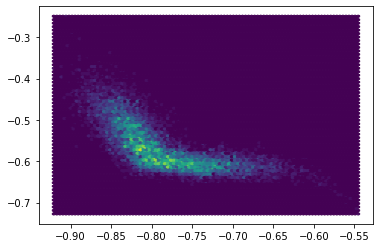

In [45]:
samples = posterior.q.sample((10000,))
plt.hexbin(samples[:,0], samples[:,1])

# 2) f divergence Variational inference

The f-divergence family is more general than $\alpha$ divergences and is given by
$$ D_f(p(x)||q(x)) = \mathbb{E}_q\left[ f \left( \frac{p(x)}{q(x)} \right)\right]$$
where $f$ is convex with $f(1) = 0$. For a convex function $f$ there exists a convex dual function $f^*$ which for $f:(0,\infty) \rightarrow \mathbb{R}$ is given by $f^*(t) = t f(1/t)$.

An bound on an f-divergence is given by 
$$ L_f(q,X) = \mathbb{E}_q \left[ f^*\left(\frac{p(\theta, X)}{q(\theta)}\right)\right]$$
An importance weighted variational bound is given by 
$$ L_f^{IW}(q, X, L) = \mathbb{E}_{\theta_1,\dots, \theta_L} \left[ f^*\left( \frac{1}{L} \sum_{l=1}^L\frac{p(\theta, X)}{q(\theta)}\right)\right]$$
If $\theta$ is reparamterizable e.g $\theta = g_\phi(\epsilon)$. Than we get unbiased MC estiamtors for the gradient by
$$ \nabla_\phi L_f(q,X) = \frac{1}{K} \sum_{k=1}^K \nabla_\phi f^*\left( \frac{p(g_\phi(\epsilon_k), X)}{q(g_\phi(\epsilon_k)}\right)$$